In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
from IPython.display import Markdown as md
from slugify import slugify

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import plastockconf as psc
from plastockconf import name_zones, name_particles, name_frequentation, name_situation
from plastockconf import particle_groups, name_substrate, name_distance, table_css_styles, table_css_styles_top

from plastock import attribute_summary, attribute_summary_test, attribute_summary_grid, add_table_to_page
import plastock as pstk

def translate_describe(x, value_column, transpose: bool = False):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    if transpose:
        df = df.T
        
    return df
import reportclass as rc
import plastock as pst
language_maps = rc.language_maps()

# a_property =  {'color' : 'red'}
# format_kwargs = dict(precision=2, thousands="'", decimal=",")
glue('blank_caption', " ", display=False)

section = 'MP'
page = ""

work_data = pd.read_csv("data/end_pipe/long_form_micro.csv")
work_data.rename(columns={'echantillon':'échantillon', 'frequentation':'fréquentation'}, inplace=True)
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")


# the regional labels for each survey location
regions = pd.read_csv("data/end_pipe/lac_leman_regions.csv")
regions.set_index('slug', drop=True, inplace=True)

# the city name of the survey locations
city_map = pd.read_csv('data/end_pipe/city_map.csv')
city_map.set_index('slug', inplace=True)

In [2]:
# ! combine souples et dur !
fibers = work_data.loc[work_data.objet == 'fibres'].copy()
not_fibers = work_data.loc[work_data.objet != 'fibres'].copy()

not_fibers['objet'] = 'fragments'

work_datai = pd.concat([fibers, not_fibers])

In [3]:
def name_the_new_distance(x, less='<= 500 m', more = '> 500 m'):
    if x == 1:
        return less
    else:
        return more

def name_the_new_freq(x, new):
    if x <= 2:
        return new
    else:
        return 'Elévée'


# the feature variables are added to the work_data
ti = work_datai.copy()
features = ['frequentation', 'situation', 'orientation', 'distance']

work_datai['slug'] = work_datai.Plage.apply(lambda x: slugify(x))
work_datai['region'] = work_datai.slug.apply(lambda x: regions.loc[x, 'alabel'])
work_datai['city'] =  work_datai.slug.apply(lambda x: city_map.loc[x, 'city'])

work_data['particules'] = work_data.compte
work_datai["particules"] = work_datai.compte

work_data['slug'] = work_data.Plage.apply(lambda x: slugify(x))
work_data['region'] = work_data.slug.apply(lambda x: regions.loc[x, 'alabel'])
work_data['city'] =  work_data.slug.apply(lambda x: city_map.loc[x, 'city'])


In [4]:
# combining variables
env_plastock = work_datai.copy()


# the substrat and distance features are being combined
# the two lowest and the two highest of each group are being combined
# substrat is a matter of combining different granularities. They are being grouped as
# sand and gravel.
# distance is now grouped by locations either less than or equal to 500 meters
env_plastock.loc[env_plastock.substrat <= 2, 'substrat'] = 1
env_plastock.loc[env_plastock.substrat > 2, 'substrat'] = 2
env_plastock.loc[env_plastock.distance <= 2, 'distance'] = 1
env_plastock.loc[env_plastock.distance > 2, 'distance'] = 2
env_plastock.loc[env_plastock["fréquentation"] <= 2, 'fréquentation'] = 2
work_data_combined = env_plastock.copy()

In [5]:
wk_dt =work_datai.groupby('échantillon', as_index=False).compte.sum()
limit = np.quantile(wk_dt.compte.values, .99)

test = wk_dt[wk_dt.compte == 0]["échantillon"].unique()
not_these = wk_dt[wk_dt.compte > limit +1]["échantillon"].unique()
not_these = [*not_these, *test]


wd_10 = work_datai[~work_datai["échantillon"].isin(not_these)].copy()
wd_10dt = wd_10.groupby('échantillon', as_index=False).compte.sum()

test = wk_dt[wk_dt.compte == 0]["échantillon"].unique()




In [6]:
wk_dt =wd_10.groupby('échantillon', as_index=False).compte.sum()
# fragments versus fibres
# eliminate anything beyond the 99th percentile

sit_disp = pd.DataFrame(translate_describe(wk_dt.compte.describe(), "résultats"))
sit_disp.loc["échantillon", "résultats"] = wd_10["échantillon"].nunique()
sit_disp.loc["total", "résultats"] = wd_10.compte.sum()
sit_disp["résultats"] = sit_disp["résultats"].astype(int)
sit_disp = sit_disp.style.set_table_styles(table_css_styles).format(**psc.format_kwargs)
sit_disp = add_table_to_page(sit_disp, 1, "", section, page, "")
glue('sit_disp_micro', sit_disp, display=False)

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
wk_dt = wd_10.groupby('échantillon', as_index=False).particules.sum()
vals = 'particules'
object_column = vals
ylim = np.quantile(wk_dt.particules.values, .99)
xlim = np.quantile(wk_dt.particules.values, .99)
sns.scatterplot(wk_dt, x="échantillon", y=vals, label='Plastock micros particules', ax=axs[0, 0])
sns.boxplot(wk_dt, y=vals,  showfliers=True, ax=axs[0, 1], dodge=False)
sns.histplot(wk_dt, x=vals,  ax=axs[1, 0], stat='probability', kde=True)
sns.ecdfplot(wk_dt, x=vals,  ax=axs[1, 1])

# axs[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

axs[0, 0].set_ylim(-1, ylim)
axs[0, 1].set_ylim(-1, ylim)
axs[1, 1].set_xlim(-1, xlim)
axs[1, 0].set_xlim(-1, xlim)
# Hide X and Y axes tick marks
axs[0,0].set_xticks([])


axs[0, 0].set_xlabel("échantillon")
axs[0, 0].set_ylabel("Particules")

axs[1, 0].set_xlabel("Particules")
axs[1, 0].set_ylabel("Probabilité")
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("Particules")
axs[0, 1].tick_params(axis="x", rotation=45)

axs[1, 1].set_xlabel("Particules")
axs[0,0].set_title("Total par échantillon", loc="left")
axs[0,1].set_title("Boîte de Tukey", loc="left")
axs[1,0].set_title("Histogramme", loc="left")
axs[1,1].set_title("Fonction de répartition", loc="left")
plt.subplots_adjust(wspace=.3)


plt.tight_layout()

glue('micro-situataion-sa', fig, display=False)
plt.close()

In [8]:
# composition of total
parts = work_data.groupby(["objet"], as_index=False).compte.sum()
parts["% du total"] = parts.compte/parts.compte.sum()

In [9]:
data = work_data[~work_data["échantillon"].isin(not_these)].groupby(['échantillon', 'objet'], as_index=False).particules.sum()
table2 = data.groupby('objet').particules.describe()
table2 = table2.reindex(['fibres', 'fdure', 'souple'])
table2 = table2.astype('int')


table2['Particule'] = table2.index.map(lambda x: psc.particle_groups[x])
caption = "hello"

table2 = table2[[table2.columns[-1], *table2.columns[:-1]]].style.set_table_styles(table_css_styles).hide(axis=0)
table2 = pst.add_table_to_page(table2, 2, caption, section, page, "", format_index="both")
glue('table2', table2, display=False)

In [10]:
data = wd_10.groupby(['échantillon', 'objet'], as_index=False).particules.sum()
table3 = data.groupby('objet').particules.describe()
table3 = table3.astype('int')
table3['Particule'] = [x.capitalize() for x in table3.index]

table3 = table3[[table3.columns[-1], *table3.columns[:-1]]].style.set_table_styles(table_css_styles)
caption = "hello"
table3 = pst.add_table_to_page(table3, 3, caption, section, page, "", format_index='both')
table3 = table3.hide(axis='index')
glue('table3', table3, display=False)

In [11]:
obj = 'fibres'
feature = 'substrat'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_substrate[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table4 = add_table_to_page(table4, 4, caption, section, page, "", format_index='both')
glue('table4', table4, display=False)

In [12]:
obj = 'fibres'
feature = 'fréquentation'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_frequentation[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table5 = add_table_to_page(table4, 5, caption, section, page, "", format_index='both')
glue('table5', table5, display=False)

In [13]:
obj = 'fibres'
feature = 'situation'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_situation[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table6 = add_table_to_page(table4, 6, caption, section, page, "", format_index='both')
glue('table6', table6, display=False)

In [14]:
obj = 'fibres'
feature = 'distance'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_distance[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table7 = add_table_to_page(table4, 7, caption, section, page, "", format_index='both')
glue('table7', table7, display=False)

In [15]:
obj = 'fdure'
feature = 'substrat'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_substrate[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table4 = add_table_to_page(table4, 8, caption, section, page, "", format_index='both')
glue('table8', table4, display=False)

In [16]:
obj = 'fdure'
feature = 'fréquentation'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_frequentation[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table5 = add_table_to_page(table4, 9, caption, section, page, "", format_index='both')
glue('table9', table5, display=False)

In [17]:
obj = 'fdure'
feature = 'situation'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_situation[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table6 = add_table_to_page(table4, 10, caption, section, page, "", format_index='both')
glue('table10', table6, display=False)

In [18]:
obj = 'fdure'
feature = 'distance'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_distance[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table7 = add_table_to_page(table4, 11, caption, section, page, "", format_index='both')
glue('table11', table7, display=False)

In [19]:
obj = 'souple'
feature = 'substrat'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_substrate[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table4 = add_table_to_page(table4, 12, caption, section, page, "", format_index='both')
glue('table12', table4, display=False)

In [20]:
obj = 'souple'
feature = 'fréquentation'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_frequentation[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table5 = add_table_to_page(table4, 13, caption, section, page, "", format_index='both')
glue('table13', table5, display=False)

In [21]:
obj = 'souple'
feature = 'situation'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_situation[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table6 = add_table_to_page(table4, 14, caption, section, page, "", format_index='both')
glue('table14', table6, display=False)

In [22]:
obj = 'souple'
feature = 'distance'

cols = ['échantillon', feature,  'objet']

data = work_data[~work_data["échantillon"].isin(not_these)].copy()
data = data[data.objet == obj].groupby(cols, as_index=False).particules.sum()
table4 = data.groupby(feature).particules.describe()
table4 = table4.astype('int')
table4[feature] = table4.index.map(lambda x: name_distance[x])
table4.set_index(feature, inplace=True, drop=True)
table4.index.name = None



table4 = table4.style.set_table_styles(table_css_styles)
caption = "hello"


table7 = add_table_to_page(table4, 15, caption, section, page, "", format_index='both')
glue('table15', table7, display=False)

# Micros particules 

__Format__ 

Le format suit celui de l'annexe pour les [microplastiques](micro_atts) . Nous incluons également l'analyse utilisant des variables combinées selon la méthode décrite dans la section [Résultats précédents](previous_results).

__Le système de mesure.__

Dans cette section, les unités sont le nombre de particules par conteneur. Le récipient a des côtés de 10 cm X 10 cm X 5 cm ou 0,0005 m³.

## Résultats

::::{grid} 1 1 2 2

:::{grid-item}

{glue}`sit_disp_micro`

:::

:::{grid-item}

From table [A1-4](micro-table-A1-4), the maximum count was 2'991 particles. This was recorded at la Pichette, where 2'593 fibers were counted in one sample. The 99th percentile of all the sample totals is 1060 particles per sample. This was exceeded three times, twice at Port Choiseul and once at la Pichette.

Here we consider the data limited to the 99th percentile, that is we are eliminating the three samples that exceeded 1061 particles.

<b>Table MP-1 :</b> Distribution des résultats de l’ensemble de l’échantillons Plastock. All values less than 1061 (90th percentile).
:::

::::

:::{card} 

{glue}`micro-situataion-sa`

+++
<b> Figure 2.2 :</b> Plastock 2022: distribution des résultats de l’ensemble de l’échantillons Plastock. The elimination of those three samples resulted in a 24 point drop in the average and a 115 point drop in the standard deviation. 
:::


(conditions_mp)=
### Conditions d'échantillonage

::::{tab-set}

:::{tab-item} Resumé
:selected:

{glue}`table2`

{glue}`table3`


::: 

:::{tab-item} Fibres

{glue}`table4`

{glue}`table5`

{glue}`table6`

{glue}`table7`

:::

:::{tab-item} Fragments

{glue}`table8`

{glue}`table9`

{glue}`table10`

{glue}`table11`
::: 

:::{tab-item} Souples

{glue}`table12`

{glue}`table13`

{glue}`table14`

{glue}`table15`
:::

::::

In [23]:
def analyze_scenario(scenario_data, func, n_iterations=100, bin_width=0.2):
    """
    Analyze a specific scenario using Random Forest regression with bootstrapping,
    and calculate feature importances.

    :param data: DataFrame containing the dataset.
    :param feature_1: The name of the first feature for filtering.
    :param feature_1_value: The value of the first feature to filter by.
    :param feature_2: The name of the second feature for filtering.
    :param feature_2_value: The value of the second feature to filter by.
    :param n_iterations: Number of bootstrap iterations. Default is 100.
    :param bin_width: Width of each bin for histogram. Default is 0.2.
    :return: A tuple containing bins, bin probabilities, flattened predictions, and feature importances.
    """
    
    # Prepare data for regression
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(scenario_data['pcs_m'].values.reshape(-1,1)).flatten()
    
    # Initialize the OneHotEncoder
    # here we encode the ordinal data
    encoder = OneHotEncoder(sparse_output=False)
    
    X = scenario_data.drop('pcs_m', axis=1)
    
    # Apply the encoder to the categorical columns
    encoded_data = encoder.fit_transform(scenario_data[['fréquentation', 'situation', 'distance', 'substrat']])
    # Create a DataFrame with the encoded data
    X_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['fréquentation', 'situation', 'distance', 'substrat']))

    
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_scaled, test_size=0.1, random_state=42)

    # Bootstrap predictions and accumulate feature importances
    bootstrap_predictions = []
        
    # Collect diagnostic at each repetition
    cum_mse = []
    cum_r2 = []
    
    for _ in range(n_iterations):
        X_train_sample, y_train_sample = resample(X_train, y_train, n_samples= len(y_train) -1)
        rf_model_sample = func
        rf_model_sample.fit(X_train_sample, y_train_sample)
        
        pred = rf_model_sample.predict(X_test)
        
        r2 = r2_score(y_test, pred)
        pred = y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
        bootstrap_predictions.append(pred)
        mse = mean_squared_error(y_test , pred)
        
        cum_mse.append(mse)
        cum_r2.append(r2)           

    # Flatten the predictions array
    predictions_flat = np.array(bootstrap_predictions).flatten()
    
    return predictions_flat, cum_mse, cum_r2

def plot_histogram(predictions, observed, title="", reference='camp-dist-1', display=False, order='predictions', xmax=800, n_bins=20, x_label='pcs/m³'):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    if order == 'predictions':
        sns.histplot(predictions, binwidth=n_bins, stat="probability", ax=ax, label='prédictions', zorder=0)
        sns.histplot(observed, binwidth=n_bins, stat="probability", label='observée', zorder=1, ax=ax)
    else:
        sns.histplot(predictions, binwidth=n_bins, stat="probability", ax=ax, label='prédictions', zorder=1)
        sns.histplot(observed, binwidth=n_bins, stat="probability", label='observée', zorder=0, ax=ax)
    ax.set_xlim(-.1, xmax)
    plt.title(title, loc='left')
    plt.xlabel(x_label)
    plt.ylabel('Densité de Probabilité')
    plt.legend()
    glue(reference, fig, display=display)
    plt.close()

def evalutate_model(r2s, mses, label, model='random-forest'):
    r2 = np.round(np.mean(r2s), 2)
    mse = np.round(np.mean(mses), 2)
    results = {"cross validated error":r2, "mean² error":mse, 'model':model}
    return pd.DataFrame(results, index=[label])

# Calculating quantiles for Scenario 2
format_kwargs = dict(precision=0, thousands="'")
q_uants = [0.01, 0.25, 0.5, 0.75, 0.99]
index = ['1%', '25%', '50%', '75%', '99%', 'Moyenne']
def makeqdf(observed, predicted, index=index, quants=q_uants, caption=""):
    
    o_q = np.quantile(observed, quants)
    m_o = np.mean(observed)
    o_p = np.quantile(predicted, quants)
    m_p = np.mean(predicted)
    
    results = {'observée':[*o_q, m_o], 'prédiction': [*o_p, m_p]}
   
    return pd.DataFrame(results, index=index).style.set_table_styles(table_css_styles_top).format(**format_kwargs).set_caption(caption)

cols = ['échantillon', 'position', 'fréquentation','situation', 'distance', 'substrat']

In [24]:
# model parameters
estimators = 10
iterations = 10

test_xt = work_data_combined[~work_data_combined["échantillon"].isin(not_these)].copy()
# the volume of the container used to sample in cm³
# sample_volume_cm = 10*10*5
# sample_volume_m = sample_volume_cm/10**6
test_xt['pcs_m'] = test_xt['compte']


# Filter for Scenario 
test_xi = test_xt[(test_xt['position'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat',  'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions_flat, feature_importances,  mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

caption = 'Ligne d\'eau'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions_flat, caption=caption)
glue('q-lignedeau-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Ligne d\'eau'
pstk.plot_histogram(predictions_flat, test_x.pcs_m.values, title=title, reference='lignedeau-sa', display=False)

In [25]:
# Filter for Scenario 

test_xt = work_data_combined[~work_data_combined["échantillon"].isin(not_these)].copy()
# the volume of the container used to sample in cm³
# sample_volume_cm = 10*10*5
# sample_volume_m = sample_volume_cm/10**6
test_xt['pcs_m'] = test_xt['compte']


# Filter for Scenario 
test_xi = test_xt.copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat',  'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importances,  mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)


caption = 'Tous les positions'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-tous-md-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions'
pstk.plot_histogram(predictions_flat, test_x.pcs_m.values, title=title, reference='tous-md-sa', display=False)

In [26]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['position'] == 2)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importances,  mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

caption = 'Plage seche'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-plageseche-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Plage seche'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='plageseche-sa', display=False)

In [27]:
# Filter for Scenario 
cols = ['échantillon', 'position', 'fréquentation','situation', 'distance', 'substrat']
test_xi = test_xt[(test_xt['position'] == 2)&(test_xt.objet == 'fibres')].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importances,  mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

caption = 'Plage seche et fibres'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-plagesechefibres-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Plage seche et fibres'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='plagesechefibres-sa', display=False)

In [28]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['substrat'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importances,  mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

caption = 'Sables fins'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-sablesfins-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Sables fins'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='sablesfins-sa', display=False)

In [29]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['substrat'] == 2)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importances,  mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

caption = 'Cailloux'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-cailloux-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Cailloux'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='cailloux-sa', display=False)

In [30]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['fréquentation'] == 3)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importances,  mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

caption = 'Fréquentation élevée'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-freq3-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Fréquentation élevée'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='freq3-sa', display=False)

In [31]:
# Filter for Scenario 
test_xi = test_xt[(test_xt['fréquentation'] == 2)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importances,  mse, r2  = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

caption = 'Fréquentation moyenne'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-freq2-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Sables fins'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='freq2-sa', display=False)

(random_forest_sa_md)=
### Random Forest 

Source : [scikit-learn random forest](https://scikit-learn.org/0.16/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

criterion : `absolute error`

La régression avec forêt aléatoire est une technique d'apprentissage automatique (machine learning) utilisée pour prédire des résultats continus (par opposition aux catégories dans la classification). C'est une méthode d'apprentissage ensembliste, ce qui signifie qu'elle combine les prédictions de plusieurs algorithmes d'apprentissage automatique pour produire des prédictions plus précises.

::::{tab-set}

:::{tab-item} Toutes les conditions
{glue}`tous-md-sa`
:::

:::{tab-item} Fréquentation moyenne
{glue}`freq2-sa`
:::

:::{tab-item} Haute fréquentation
{glue}`freq3-sa`
:::

:::{tab-item} Cailloux
{glue}`cailloux-sa`
:::

:::{tab-item} Sables fins
{glue}`sablesfins-sa`
:::

:::{tab-item} Plage seche et sable fins
{glue}`plagesechefibres-sa`

:::

:::{tab-item} Plage seche
{glue}`plageseche-sa`

:::

:::{tab-item} Ligne d'eau
{glue}`lignedeau-sa`

:::


:::{tab-item} Résultats
:selected:

````{grid} 1 2 2 2

```{grid-item}
{glue}`q-tous-md-sa`
```

```{grid-item}

Les modèles ont fait l'objet d'un bootstrap, 100 itérations pour chaque scénario. Les résultats estimés sont la collection de toutes les prédictions de chaque itération.

Par exemple, le tableau intitulé "Gravier" présente les résultats observés et prévus pour les plages ayant un substrat de 3 ou 4.

```

```{grid-item}
{glue}`q-freq2-sa`
```

```{grid-item}
{glue}`q-freq3-sa`
```

```{grid-item}
{glue}`q-cailloux-sa`
```

```{grid-item}
{glue}`q-sablesfins-sa`
```

```{grid-item}
{glue}`q-plagesechefibres-sa`
```

```{grid-item}
{glue}`q-plageseche-sa`
```

```{grid-item}
{glue}`q-lignedeau-sa`
```

````
:::

::::
    

,observée,prédiction
1%,23.18,0.00
25%,71.25,40.75
50%,122.00,88.50
75%,194.00,188.00
99%,867.17,742.07
Moyenne,159.67,145.56


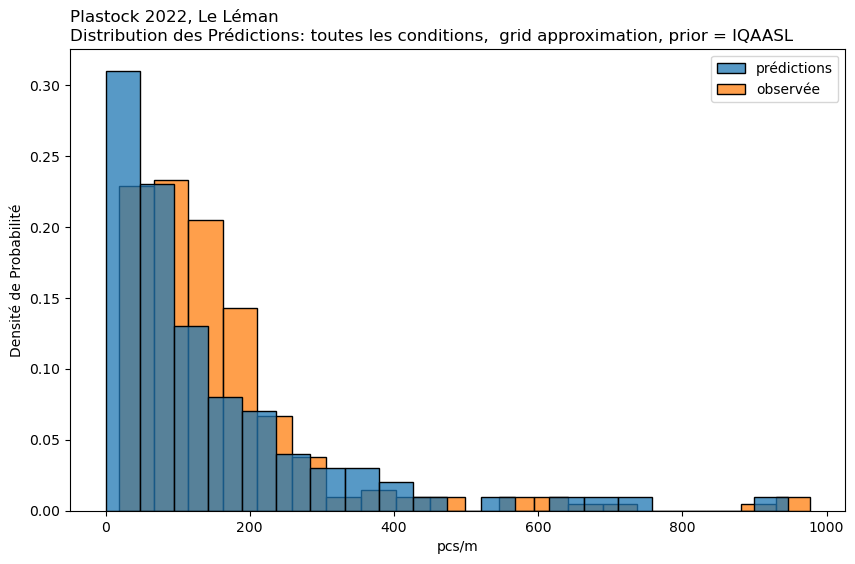

In [32]:
col = 'top'
pcs_col = 'pcs_m'
cols = ['échantillon', 'fréquentation', 'situation', 'distance', 'substrat']
grid_range = np.arange(0, 1001)
bins = [1]

beta_prior = pstk.calculate_beta_prior(grid_range=grid_range, bin_density_numbers=[1])
test_xt = work_data_combined[~work_data_combined["échantillon"].isin(not_these)].copy()
test_xt['pcs_m'] = test_xt['compte']
test_x = test_xt.copy().groupby(cols, as_index=False)[pcs_col].sum()
test_x['top'] = 1

grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock1 = pstk.define_posterior(grid_pstock.copy(), beta_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock1)

caption = 'Toutes les conditions'

test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
glue('q-tous-b-sa', test_grid_quants, display=True)

title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: toutes les conditions,  grid approximation, prior = IQAASL'

pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='toutes-gapprox-sa', display=True)

In [33]:
col = 'substrat'
pcs_col = 'pcs_m'
# grid_range = grid_val_index
bins = [2]
test_xt = work_data_combined[~work_data_combined["échantillon"].isin(not_these)].copy()
test_xt['pcs_m'] = test_xt['compte']

test_xt = test_xt[(test_xt['substrat'] == 2)].copy()

test_x = test_xt.groupby(cols, as_index=False)[pcs_col].sum()

grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())

caption = 'Sable'

test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
glue('q-sable-b-sa', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Sable, grid approximation'

pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='sables-gapprox-sa', display=False)

<Axes: xlabel='X', ylabel='Bin_1'>

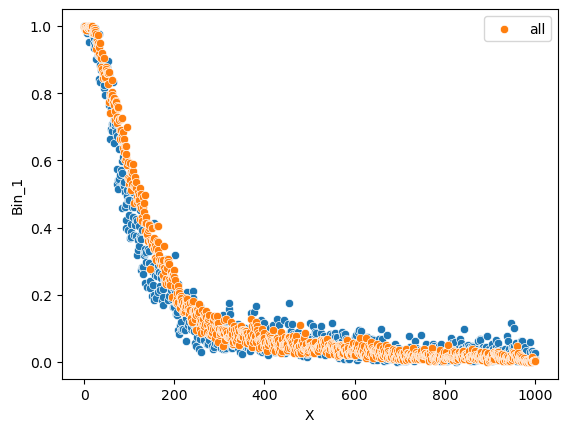

In [34]:
fig, ax = plt.subplots()

sns.scatterplot(data=post_grid_pstock, x="X", y="Bin_1")
sns.scatterplot(data=post_grid_pstock1, x="X", y="Bin_1", label="all")

In [35]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: main

pandas    : 2.0.0
matplotlib: 3.7.1
numpy     : 1.24.2
seaborn   : 0.12.2

